In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng

In [2]:
# Initialize RNG for reproducibility
rng = default_rng(seed=42)

Ground Truth Templates:


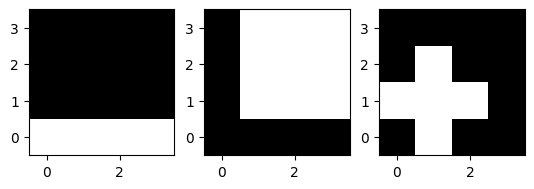

In [3]:
# Create templates
templates = []

template1 = np.array([
    [1, 1, 1, 1],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
])

template2 = np.array([
    [0, 0, 0, 0],
    [0, 1, 1, 1],
    [0, 1, 1, 1],
    [0, 1, 1, 1]
])

template3 = np.array([
    [0, 1, 0, 0],
    [1, 1, 1, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 0]
])

templates = np.array([template1, template2, template3])
templates_flat = templates.reshape(3, -1)

print("Ground Truth Templates:")
# Plot the original templates
fig, axs = plt.subplots(1, 3)
for i, template in enumerate(templates):
    axs[i].imshow(template, cmap = "gray", origin="lower")
plt.show()

Random Samples from Dataset:


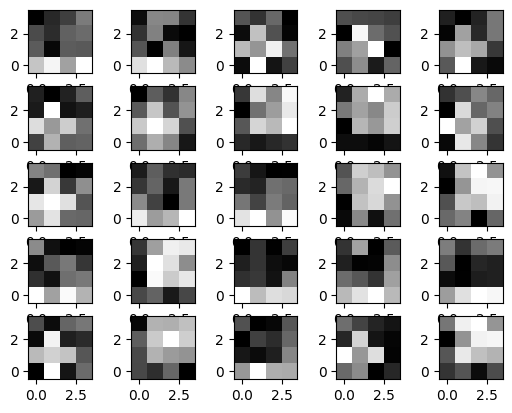

In [4]:
# Create a dataset
size = 10000
pi_true = np.ones(templates_flat.shape[0]) / templates_flat.shape[0]
z = rng.choice(3, size=size, p=pi_true)
means = templates_flat[z]
rand_noise = rng.random((size, templates.shape[1] * templates.shape[2]))
dataset = means + rand_noise
N, D = dataset.shape

print("Random Samples from Dataset:")
# Plot a random selection of 25 datapoints from the dataset
fig, axs = plt.subplots(5, 5)
axs = axs.flatten()
rand_selection = rng.choice(size, 25)
for i, datapoint in enumerate(dataset[rand_selection]):
    axs[i].imshow(datapoint.reshape(templates.shape[1], templates.shape[2]), cmap = "gray", origin="lower")
plt.show()

In [5]:
# Multivariate Gaussian PDF
def mv_gaussian(
        X: np.ndarray, 
        mean: np.ndarray, 
        cov: np.ndarray):
    '''
    Multivariate Gaussian probability density function.

    Parameters
    ----------
    X : np.ndarray
        Data points, shape (N, D).

    mean : np.ndarray
        Mean vector, shape (D,).
        
    cov : np.ndarray
        Covariance matrix, shape (D, D).
    
    Returns
    -------
    P(X): np.ndarray
        Probability density at each data point, shape (N,).
    '''
    D = X.shape[1]
    diff = X - mean
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)
    norm_const = 1. / np.sqrt((2 * np.pi) ** D * det_cov)
    exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
    return norm_const * np.exp(exponent)

In [6]:
# E-M algorithm
def run_em(
        dataset: np.ndarray, 
        K: int, 
        max_iters: int = 10000, 
        tol: float = 1e-6):
    '''
    Run the Expectation-Maximization algorithm for Gaussian Mixture Models.

    Parameters
    ----------
    dataset : np.ndarray
        Input data, shape (N, D).
    
    K : int
        Number of Gaussian components.

    max_iters : int, optional
        Maximum number of iterations, default is 10000.

    tol : float, optional
        Tolerance for convergence, default is 1e-6.

    Returns
    -------
    pi : np.ndarray
        Mixing coefficients, shape (K,).

    mu : np.ndarray
        Mean vectors, shape (K, D).

    cov : np.ndarray
        Covariance matrices, shape (K, D, D).

    lls : np.ndarray
        Log-likelihoods at each iteration, shape (iters,).
    '''
    N, D = dataset.shape
    pi = np.ones(K) / K
    mu = rng.random((K, D))
    cov = np.repeat(np.eye(D)[np.newaxis], K, axis=0)

    prev_ll = None
    lls = np.zeros(max_iters)

    for iteration in range(max_iters):
        # E-step
        pdfs = np.zeros((N, K))
        for k in range(K):
            pdfs[:, k] = mv_gaussian(dataset, mu[k], cov[k])
        weighted_pdfs = pdfs * pi
        resp = weighted_pdfs / np.sum(weighted_pdfs, axis=1, keepdims=True)

        Nk = np.sum(resp, axis=0)

        # M-step
        pi = Nk / N
        mu = (resp.T @ dataset) / Nk[:, None]
        cov = np.zeros((K, D, D))
        for k in range(K):
            diff = dataset - mu[k]
            cov[k] = (resp[:, k][:, None] * diff).T @ diff / Nk[k]

        # Log-likelihood
        ll = np.sum(np.log(np.sum(weighted_pdfs, axis=1)))
        lls[iteration:] = ll
        if prev_ll is not None and np.abs(ll - prev_ll) < tol:
            print(f"Convergence detected at iteration: {iteration+1}!")
            break
        prev_ll = ll

    return pi, mu, cov, lls[:iteration]

Convergence detected at iteration: 429!
Log Likelihood:


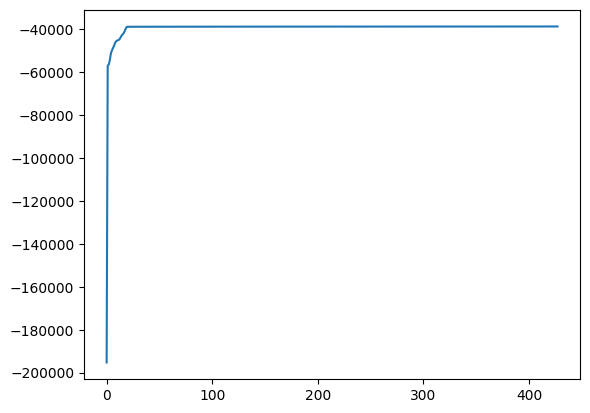

Estimated Templates:


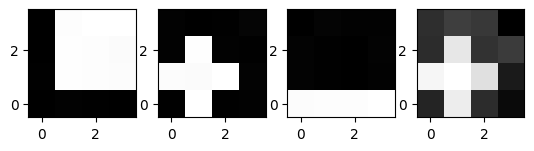

In [7]:
# Set the number of templates to estimate
K = 4

# Run EM
pi_est, mu_est, cov_est, lls = run_em(dataset, K=K)
estimated_templates = mu_est.reshape(-1, 4, 4)

print("Log Likelihood:")
# Plot the log likelihood of the data
plt.plot(lls)
plt.show()

print("Estimated Templates:")
# Plot the estimated templates
fig, axs = plt.subplots(1, K)
for i, template in enumerate(estimated_templates):
    axs[i].imshow(template, cmap = "gray", origin="lower")
plt.show()